In [1]:
import bt
from datetime import date
import model as model
from model import Security, Exchange, DataVendor, Quotation
from database import db_session, db_engine, Base
from datetime import datetime, timedelta, date
import pandas as pd
%matplotlib inline

### Try a very simple backtest using our sqlAlchemy data

In [2]:
# Load data from database
df1 = Quotation.get_dataframe("BPE5.DE")
df2 = Quotation.get_dataframe("PFE")

# Change format to the one expected by bt

# Price (adj_close) equals name of security
df1.rename(columns={'adj_close':'BPE5.DE'}, inplace=True)
df2.rename(columns={'adj_close':'PFE'}, inplace=True)

# Date column upper case
df1.rename(columns={'date': 'Date'}, inplace=True)
df2.rename(columns={'date': 'Date'}, inplace=True)

# Date as index
df1.set_index("Date", inplace=True)
df2.set_index("Date", inplace=True)

# Drop unneeded columns
df1.drop(columns = ["id", "open", "high", "low", "close", "volume", "created_date", "last_updated", "data_vendor_id", "security_id"], axis = 1, inplace = True)
df2.drop(columns = ["id", "open", "high", "low", "close", "volume", "created_date", "last_updated", "data_vendor_id", "security_id"], axis = 1, inplace = True)

C:\Users\Fabian\Anaconda3\lib\site-packages\sqlalchemy\sql\sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [3]:
data = pd.merge_ordered(df1, df2, on = "Date", how = "outer")
data.set_index("Date", inplace = True)

In [4]:
data.to_clipboard()

In [5]:
data.drop_duplicates(inplace = True)

In [6]:
# Select only times > 2005
data = data[data.index > datetime(2005,1,1)]

In [7]:
# Fill nans
data.fillna(method="ffill", inplace = True)

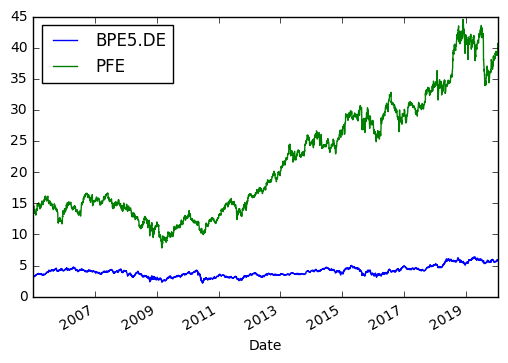

In [8]:
data.plot()

In [9]:
# create the strategy
s1 = bt.Strategy('s1', [bt.algos.RunAfterDate(date(2005,1,1)), bt.algos.RunWeekly(), bt.algos.SelectAll(), bt.algos.WeighEqually(),bt.algos.Rebalance()])

test_s1 = bt.Backtest(s1, data, initial_capital = 100000)

# Create a second strategy - buy equally - and hold forever
s_long = bt.Strategy('long', [bt.algos.RunAfterDate(date(2005,1,1)),
                              bt.algos.RunOnce(),
                              bt.algos.SelectAll(),
                              bt.algos.WeighEqually(),
                              bt.algos.Rebalance()])

test_s_long = bt.Backtest(s_long, data, initial_capital=100000)

In [10]:
# create a backtest and run it
res = bt.run(test_s_long, test_s1)

long
0% [############################# ] 100% | ETA: 00:00:00s1
0% [############################# ] 100% | ETA: 00:00:00

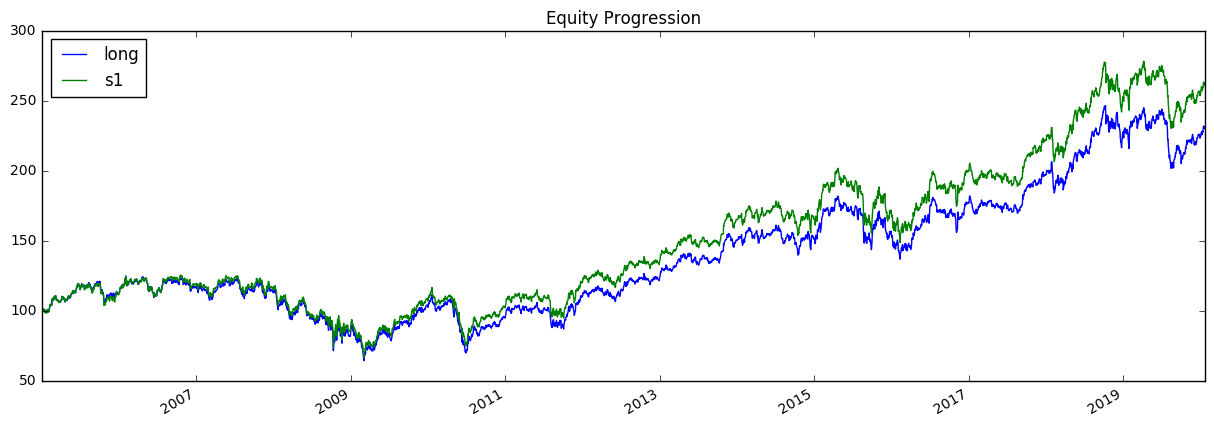

In [11]:
res.plot()

In [12]:
res.display_lookback_returns()

,long,s1
mtd,2.62%,2.63%
3m,7.85%,7.17%
6m,-1.32%,-0.29%
ytd,2.62%,2.63%
1y,0.24%,1.35%
3y,10.53%,10.74%
5y,7.72%,8.46%
10y,7.87%,8.77%
incep,5.69%,6.58%


In [ ]:
# Weekly rebalancing was slightly better than buy and hold